# Imports

In [2]:
import datetime
import talib as ta
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from skopt.plots import plot_objective, plot_evaluations

from backtesting import Backtest, Strategy
from backtesting.lib import crossover, plot_heatmaps


# Load & Process data

In [3]:
from backtesting.test import GOOG

factor = 1_000_000
GOOG['Open'] /= factor
GOOG['High'] /= factor
GOOG['Low'] /= factor
GOOG['Close'] /= factor

data = GOOG

# Strategy Class

In [81]:
size = 4

class Base_Strategy(Strategy):
 
    upper_bound = 70
    lower_bound = 30
    rsi_window = 14
    
    # Do as much initial computation as possible
    def init(self):
        self.rsi = self.I(ta.RSI, self.data.Close, self.rsi_window)

    # Step through bars one by one
    # Note that multiple buys are a thing here
    def next(self):        
        price = self.data.Close[-1]
        if crossover(self.rsi, self.upper_bound):
            self.position.close()
        elif crossover(self.lower_bound, self.rsi) and not self.position:
            stop = price - 0.1*price
            oneR = abs(price - stop)
            take_profit = price + (1.2 * oneR)
            params = [self.lower_bound, self.upper_bound]
            self.buy(size=size-1,sl=stop,tag=[oneR,size,"initial",params])
            self.buy(size=1,sl=stop,tp=take_profit,tag=[oneR,size,"portion",params])

# Test Run

# Single Run Test

In [82]:
bt = Backtest(data, Base_Strategy, cash=100, commission=.002)
stats = bt.run()
print(stats)
bt.plot()

Start                     2004-08-19 00:00:00
End                       2013-03-01 00:00:00
Duration                   3116 days 00:00:00
Exposure Time [%]                    24.90689
Equity Final [$]                   108.132489
Equity Peak [$]                    108.223438
Return [R]                           8.132489
Buy & Hold Return [%]              703.458242
Return (Ann.) [%]                    0.921498
Volatility (Ann.) [%]                1.838895
Max. Drawdown [%]                   -3.702339
Avg. Drawdown [%]                   -0.438122
Max. Drawdown Duration      567 days 00:00:00
Avg. Drawdown Duration       43 days 00:00:00
# Trades                                   17
Win Rate [%]                        52.941176
Best Trade [R]                       3.394274
Worst Trade [R]                     -1.191483
Expectancy (mean R)                  0.478382
Profit Factor                        2.123061
SQN                                  1.327839
Max. Trade Duration          87 da

Row(id='8944', ...)

# Optimise Test

In [84]:
bt = Backtest(data, Base_Strategy, cash=100, commission=.002/factor)
stats, heatmap, optimize_result  = bt.optimize(
    upper_bound = [50, 100],
    lower_bound = [20, 50],
    rsi_window = [5, 30],
    maximize = "SQN",
    method = "skopt",
    constraint = lambda param: param.upper_bound > param.lower_bound,
    max_tries = 50,
    random_state=0,
    return_heatmap=True,
    return_optimization=True
    )

bt.plot(resample=False)

trades = stats['_trades'].drop('ReturnPct', axis=1)
trades.Size /= size
trades.EntryPrice = round(trades.EntryPrice * factor,2)
trades.ExitPrice = round(trades.ExitPrice * factor,2)
trades.PnL = round(trades.PnL,2)
trades.OneR = round(trades.OneR * factor,2)

print(stats)
print(trades.to_string())
print(str(stats._strategy))

Backtest.optimize:   0%|          | 0/50 [00:00<?, ?it/s]

Start                     2004-08-19 00:00:00
End                       2013-03-01 00:00:00
Duration                   3116 days 00:00:00
Exposure Time [%]                   66.945996
Equity Final [$]                   114.632552
Equity Peak [$]                    114.730214
Return [R]                          14.632552
Buy & Hold Return [%]              703.458242
Return (Ann.) [%]                    1.615022
Volatility (Ann.) [%]                 2.23813
Max. Drawdown [%]                   -3.005872
Avg. Drawdown [%]                   -0.551137
Max. Drawdown Duration      717 days 00:00:00
Avg. Drawdown Duration       51 days 00:00:00
# Trades                                   18
Win Rate [%]                        55.555556
Best Trade [R]                       3.929672
Worst Trade [R]                     -1.274349
Expectancy (mean R)                   0.81292
Profit Factor                        2.985313
SQN                                  1.986021
Max. Trade Duration         327 da

# Walk forward

In [18]:
lookback_bars = int(len(data) / 5)
validation_bars = int(len(data) / 10)

for i in range(lookback_bars, len(data) - validation_bars, validation_bars):
    start = data.index[i-lookback_bars]
    end = data.index[i]
    print('Training: ' + str(start) + ' to ' + str(end))
    start = data.index[i+1]
    end = data.index[i+validation_bars]
    print('Validation: ' + str(start) + ' to ' + str(end))
    print('-----')

Training: 2004-08-19 00:00:00 to 2006-05-03 00:00:00
Validation: 2006-05-04 00:00:00 to 2007-03-12 00:00:00
-----
Training: 2005-06-24 00:00:00 to 2007-03-12 00:00:00
Validation: 2007-03-13 00:00:00 to 2008-01-15 00:00:00
-----
Training: 2006-05-02 00:00:00 to 2008-01-15 00:00:00
Validation: 2008-01-16 00:00:00 to 2008-11-18 00:00:00
-----
Training: 2007-03-09 00:00:00 to 2008-11-18 00:00:00
Validation: 2008-11-19 00:00:00 to 2009-09-25 00:00:00
-----
Training: 2008-01-14 00:00:00 to 2009-09-25 00:00:00
Validation: 2009-09-28 00:00:00 to 2010-08-03 00:00:00
-----
Training: 2008-11-17 00:00:00 to 2010-08-03 00:00:00
Validation: 2010-08-04 00:00:00 to 2011-06-08 00:00:00
-----
Training: 2009-09-24 00:00:00 to 2011-06-08 00:00:00
Validation: 2011-06-09 00:00:00 to 2012-04-13 00:00:00
-----
Training: 2010-08-02 00:00:00 to 2012-04-13 00:00:00
Validation: 2012-04-16 00:00:00 to 2013-02-21 00:00:00
-----


# Run walk-forward training

In [97]:
def walk_forward(
    strategy,
    data,
    lookback_bars,
    validation_bars,
    cash = 100,
    commission = 0.002/factor
    ):
    
    parameters_training_all = []
    trades_training_all = []
    stats_training_all = []
            
    for i in tqdm(range(lookback_bars, len(data) - validation_bars, validation_bars)):
        
        start = data.index[i-lookback_bars]
        end = data.index[i]
        
        class WF(strategy):

            start_date = start
            end_date = end

            def init(self):
                super().init()

            def next(self):
                # only call the strategy if in training period
                if self.start_date <= self.data.index[-1] < self.end_date:
                    super().next()

        bt_training = Backtest(data, WF, cash=cash, commission=commission)
        stats_training, heatmap, optimize_result = bt_training.optimize(
            upper_bound = [50, 100],
            lower_bound = [20, 50],
            rsi_window = [10, 30],
            maximize = "SQN",
            method = "skopt",
            constraint = lambda param: param.upper_bound > param.lower_bound,
            max_tries = 50,
            random_state=0,
            return_heatmap=True,
            return_optimization=True
            )
        
        trades = stats_training['_trades'].drop('ReturnPct', axis=1)
        trades.Size /= size
        trades.EntryPrice = round(trades.EntryPrice * factor,2)
        trades.ExitPrice = round(trades.ExitPrice * factor,2)
        trades.PnL = round(trades.PnL,2)
        trades.OneR = round(trades.OneR * factor,2)

        # return
        parameters_training_all.append([stats_training._strategy.lower_bound, stats_training._strategy.upper_bound, stats_training._strategy.rsi_window])
        trades_training_all.append(trades)    
        stats_training_all.append(stats_training)
        
    return parameters_training_all, trades_training_all, stats_training_all

In [98]:
lookback_bars = int(len(data) / 5)
validation_bars = int(len(data) / 10)
parameters, trades_training, stats_training = walk_forward(
    Base_Strategy,
    data,
    lookback_bars=lookback_bars,
    validation_bars=validation_bars,
)


  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/50 [00:00<?, ?it/s]


 12%|██████████▌                                                                         | 1/8 [00:09<01:03,  9.07s/it]

Backtest.optimize:   0%|          | 0/50 [00:00<?, ?it/s]


 25%|█████████████████████                                                               | 2/8 [00:18<00:55,  9.19s/it]

Backtest.optimize:   0%|          | 0/50 [00:00<?, ?it/s]


 38%|███████████████████████████████▌                                                    | 3/8 [00:27<00:46,  9.25s/it]

Backtest.optimize:   0%|          | 0/50 [00:00<?, ?it/s]


 50%|██████████████████████████████████████████                                          | 4/8 [00:37<00:37,  9.48s/it]

Backtest.optimize:   0%|          | 0/50 [00:00<?, ?it/s]


 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:47<00:28,  9.59s/it]

Backtest.optimize:   0%|          | 0/50 [00:00<?, ?it/s]


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:57<00:19,  9.64s/it]

Backtest.optimize:   0%|          | 0/50 [00:00<?, ?it/s]


 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [01:07<00:09,  9.81s/it]

Backtest.optimize:   0%|          | 0/50 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:16<00:00,  9.62s/it]


In [99]:
print(parameters)

[[45, 67, 19], [45, 67, 19], [40, 52, 23], [43, 79, 27], [49, 81, 11], [35, 64, 27], [33, 72, 11], [33, 72, 11]]


# Run walk forward live

In [100]:
def walk_forward_live(
    strategy,
    data_full,
    lookback_bars,
    validation_bars,
    cash = 100,
    commission = 0.002/factor
    ):
    
            
    dates = [data_full.index[i+1] for i in range(lookback_bars, len(data_full) - validation_bars, validation_bars)]
    lower_bounds = [parameter[0] for parameter in parameters]
    upper_bounds = [parameter[1] for parameter in parameters]
    
    data_live = data_full.iloc[lookback_bars + 1 - parameters[0][2]:]
        
    class WF_Live(strategy):

        def init(self):
            rsi_windows = [parameter[2] for parameter in parameters]
            self.rsi0 =  self.I(ta.RSI, self.data.Close, rsi_windows[0])
            self.rsi1 =  self.I(ta.RSI, self.data.Close, rsi_windows[1])
            self.rsi2 =  self.I(ta.RSI, self.data.Close, rsi_windows[2])
            self.rsi3 =  self.I(ta.RSI, self.data.Close, rsi_windows[3])
            self.rsi4 =  self.I(ta.RSI, self.data.Close, rsi_windows[4])
            self.rsi5 =  self.I(ta.RSI, self.data.Close, rsi_windows[5])
            self.rsi6 =  self.I(ta.RSI, self.data.Close, rsi_windows[6])
            super().init()
            
        def next(self):
            
            if dates[0] <= self.data.index[-1]  < dates[1]:
                self.lower_bound = lower_bounds[0]
                self.upper_bound = upper_bounds[0]
                self.rsi = self.rsi0
            elif dates[1] <= self.data.index[-1]  < dates[2]:
                self.lower_bound = lower_bounds[1]
                self.upper_bound = upper_bounds[1]
                self.rsi = self.rsi1
            elif dates[2] <= self.data.index[-1]  < dates[3]:
                self.lower_bound = lower_bounds[2]
                self.upper_bound = upper_bounds[2]
                self.rsi = self.rsi2
            elif dates[3] <= self.data.index[-1]  < dates[4]:
                self.lower_bound = lower_bounds[3]
                self.upper_bound = upper_bounds[3]
                self.rsi = self.rsi3
            elif dates[4] <= self.data.index[-1]  < dates[5]:
                self.lower_bound = lower_bounds[4]
                self.upper_bound = upper_bounds[4]
                self.rsi = self.rsi4
            elif dates[5] <= self.data.index[-1]  < dates[6]:
                self.lower_bound = lower_bounds[5]
                self.upper_bound = upper_bounds[5]
                self.rsi = self.rsi5
            elif self.data.index[-1]  >= dates[6]:
                self.lower_bound = lower_bounds[6]
                self.upper_bound = upper_bounds[6]
                self.rsi = self.rsi6
            
            super().next()
            

    bt_live = Backtest(data_live, WF_Live, cash=100, commission=.002)
    stats_live = bt_live.run()

    trades = stats_live['_trades'].drop('ReturnPct', axis=1)
    trades.Size /= size
    trades.EntryPrice = round(trades.EntryPrice * factor,2)
    trades.ExitPrice = round(trades.ExitPrice * factor,2)
    trades.PnL = round(trades.PnL,2)
    trades.OneR = round(trades.OneR * factor,2)
    
    bt_live.plot()
        
    return trades, stats_live

In [101]:
trades, stats = walk_forward_live(
    Base_Strategy,
    data,
    lookback_bars=lookback_bars,
    validation_bars=validation_bars
)

In [92]:
stats

Start                     2006-04-06 00:00:00
End                       2013-03-01 00:00:00
Duration                   2521 days 00:00:00
Exposure Time [%]                   55.613126
Equity Final [$]                     111.1795
Equity Peak [$]                    111.274945
Return [R]                            11.1795
Buy & Hold Return [%]               96.067416
Return (Ann.) [%]                    1.549353
Volatility (Ann.) [%]                2.207505
Max. Drawdown [%]                   -4.266217
Avg. Drawdown [%]                   -0.425499
Max. Drawdown Duration      783 days 00:00:00
Avg. Drawdown Duration       47 days 00:00:00
# Trades                                   20
Win Rate [%]                             55.0
Best Trade [R]                       9.071204
Worst Trade [R]                     -1.418841
Expectancy (mean R)                  0.558975
Profit Factor                        2.177602
SQN                                  1.066553
Max. Trade Duration         341 da

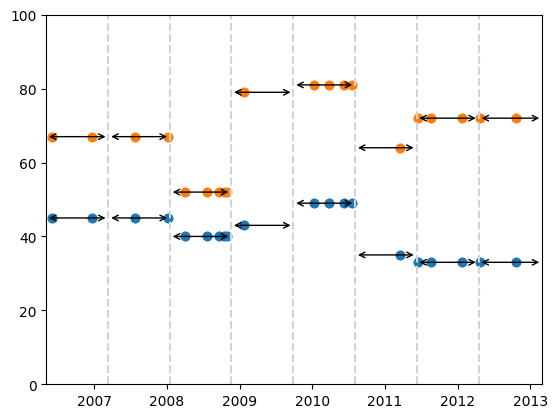

In [94]:
dates = [data.index[i+1] for i in range(lookback_bars, len(data) - validation_bars, validation_bars)] + [data.index[-1]]
param = [param[0] for param in trades.Params]

plt.plot(trades.EntryTime, [param[0] for param in trades.Params], marker='o', linestyle='')
plt.plot(trades.EntryTime, [param[1] for param in trades.Params], marker='o', linestyle='')
for i in range(len(dates)-1):
    plt.annotate('', xy=(dates[i], parameters[i][0]), xytext=(dates[i + 1], parameters[i][0]),
             arrowprops=dict(arrowstyle='<->', lw=1, color='black'))
    
    plt.annotate('', xy=(dates[i], parameters[i][1]), xytext=(dates[i + 1], parameters[i][1]),
             arrowprops=dict(arrowstyle='<->', lw=1, color='black'))
    plt.axvline(x=pd.Timestamp(dates[i]), color='lightgray', linestyle='--')
    
    
plt.ylim(0,100)
plt.xlim(dates[0],dates[-1])
plt.show()

# Plots

# Plot stats of a particular training result

In [19]:
def plot_stats(data_full, stats):
    equity_curve = stats._equity_curve
    aligned_data = data_full.reindex(equity_curve.index)
    
    bt = Backtest(aligned_data, Base_Strategy, cash=100, commission=0.002)
    bt.plot(results = stats)

In [21]:
plot_stats(data, stats_training[0])

In [22]:
stats_training[0]._trades

Size  EntryBar  ExitBar  EntryPrice  ExitPrice       PnL  ReturnPct  \
0      1        65       85    0.000169   0.000188  0.271675   0.107453   
1      1        80       89    0.000173   0.000192  0.287411   0.114389   
2      1        77       89    0.000171   0.000192  0.310781   0.124851   
3      1       108      115    0.000189   0.000216  0.351639   0.140070   
4      1       153      169    0.000181   0.000201  0.280074   0.111144   
5      1       166      170    0.000185   0.000223  0.512849   0.205196   
6      1       131      170    0.000190   0.000223  0.441682   0.176078   
7      1       129      170    0.000194   0.000223  0.381635   0.150828   
8      1       121      170    0.000192   0.000223  0.398607   0.158801   
9      3       166      171    0.000185   0.000218  1.332602   0.177729   
10     3       153      171    0.000181   0.000218  1.537787   0.203417   
11     3       131      171    0.000190   0.000218  1.123340   0.149274   
12     3       129      171    0.000194   0.000218  0.945814   0.124600   
13     3       121      171    0.000192   0.000218  0.996949   0.132392   
14     3       108      171    0.000189   0.000218  1.145340   0.152076   
15     3        80      171    0.000173   0.000218  1.979566   0.262620   
16     3        77      171    0.000171   0.000218  2.061890   0.276109   
17     3        65      171    0.000169   0.000218  2.165832   0.285542   
18     1       295      297    0.000305   0.000346  0.339554   0.135230   
19     1       290      297    0.000306   0.000346  0.326606   0.130766   
20     1       244      297    0.000294   0.000346  0.441361   0.175442   
21     1       238      297    0.000293   0.000346  0.452093   0.181316   
22     1       297      297    0.000346   0.000346 -0.005703  -0.001996   
23     3       297      304    0.000346   0.000372  0.627516   0.073215   
24     3       295      304    0.000305   0.000372  1.663117   0.220782   
25     3       290      304    0.000306   0.000372  1.618334   0.215982   
26     3       244      304    0.000294   0.000372  1.992632   0.264025   
27     3       238      304    0.000293   0.000372  2.022207   0.270342   
28     1       346      349    0.000423   0.000465  0.248748   0.097500   
29     1       362      366    0.000440   0.000389 -0.296704  -0.116682   
30     3       362      366    0.000440   0.000389 -0.890111  -0.116682   
31     1       358      366    0.000440   0.000389 -0.289537  -0.114991   
32     3       358      366    0.000440   0.000389 -0.868612  -0.114991   
33     3       346      368    0.000423   0.000373 -0.903757  -0.118080   
34     1       389      410    0.000366   0.000412  0.315960   0.127196   
35     1       385      410    0.000369   0.000408  0.268207   0.105343   
36     1       451      473    0.000377   0.000425  0.316522   0.127451   
37     1       457      474    0.000382   0.000427  0.299202   0.119643   
38     1       436      540    0.000384   0.000433  0.317396   0.127848   
39     1       428      548    0.000402   0.000459  0.357908   0.142101   
40     3       457      549    0.000382   0.000462  1.584726   0.211229   
41     3       451      549    0.000377   0.000462  1.686979   0.226427   
42     3       436      549    0.000384   0.000462  1.511103   0.202892   
43     3       428      549    0.000402   0.000462  1.135582   0.150287   
44     3       389      549    0.000366   0.000462  1.966788   0.263923   
45     3       385      549    0.000369   0.000462  1.923147   0.251783   

   StopLoss  EntryTime   ExitTime      OneR    Params Duration  
0   portion 2004-11-19 2004-12-20  0.000017  [48, 79]  31 days  
1   portion 2004-12-13 2004-12-27  0.000017  [48, 79]  14 days  
2   portion 2004-12-08 2004-12-27  0.000017  [48, 79]  19 days  
3   portion 2005-01-24 2005-02-02  0.000019  [48, 79]   9 days  
4   portion 2005-03-30 2005-04-21  0.000018  [48, 79]  22 days  
5   portion 2005-04-18 2005-04-22  0.000019  [48, 79]   4 days  
6   portion 2005-02-25 

# Plot walkforward periods

In [71]:
def plot_period_graph(
    data,
    lookback_bars,
    validation_bars):
    
    ranges = list(range(lookback_bars, len(data) - validation_bars, validation_bars))
    
    fig, ax = plt.subplots()
    fig.set_figwidth(12)
    
    for i in range(len(ranges)):
        
        training_data = data.iloc[ranges[i]-lookback_bars:ranges[i]]
        validation_data = data.iloc[ranges[i]:ranges[i]+validation_bars]
        
        plt.fill_between(training_data.index,
                        [len(ranges) - i - 0.5]*len(training_data.index),
                        [len(ranges) - i + 0.5]*len(training_data.index),
                         color = "blue"
                        )
        
        plt.fill_between(validation_data.index,
                        [len(ranges) - i - 0.5]*len(validation_data.index),
                        [len(ranges) - i + 0.5]*len(validation_data.index),
                         color = "orange"
                        )
    
    plt.show()

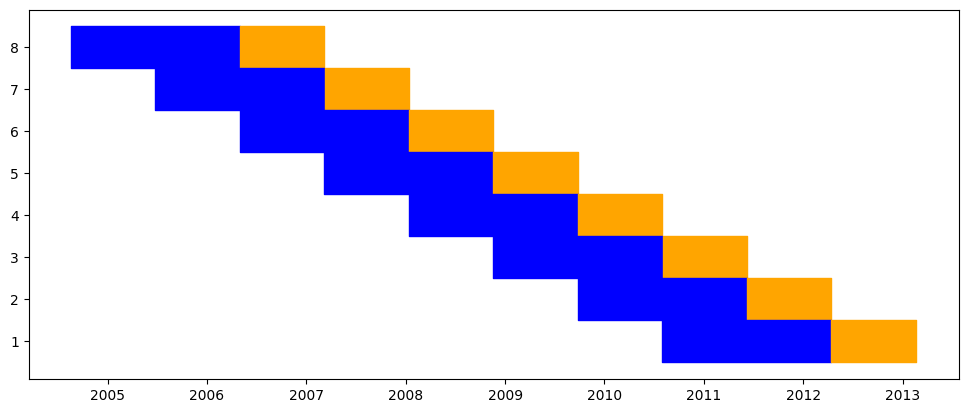

In [72]:
plot_period_graph(data,lookback_bars,validation_bars)